In [1]:
############### IMPORT LIBRARIES ###############
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [2]:
############### DEFINE MODEL HYPERPARAMETERS ######################
N = 5                                                                 # No of sides of the polygon

In [3]:
########## MODEL CLASSES ###############

class ConstraintLayer(nn.Module):
    """
    ConstraintLayer is used to rotate and scale the centers given by encoder such that the inner shapes fit inside outer shape

    Methods:
        __init__: Defines variables.
        forward: Does forward pass through the layer
    """

    def __init__(self, R, maxnorm, input_shape):
        """
        Initializes ConstraintLayer needed variables

        Args:
            R (torch.tensor): Circumradius of the polygon
            maxnorm (torch.tensor) : Vector of all inner radii
            input_shape (torch.tensor) : Shape of input in forward pass

        Variables:
            weight(torch.tensor) : Parameter used for allowing rotation of center location
            a (torch.tensor) : Parameter used for allowing scaling of the center location
        """

        super(ConstraintLayer, self).__init__()
        self.maxnorm = maxnorm
        self.R = torch.tensor(R)
        self.weight = torch.nn.Parameter(data=torch.randn(input_shape),requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        self.a = torch.nn.Parameter(data=torch.randn(input_shape[0],1)-0.75, requires_grad=True)
         
    def forward(self, inputs):
        """
        Forward pass through the constraint layer

        Args:
            inputs (torch.tensor) : Input to the forward pass
        Returns:
            output (torch.tensor) : Output through the layer
        """

        rotation_vector = self.weight / (torch.norm(self.weight, dim=1, p=2, keepdim=True).detach())
        inputs = inputs / torch.norm(inputs, dim=1, p=2, keepdim=True).detach()
        mul = torch.cat(((rotation_vector[:,0]*inputs[:,0]-rotation_vector[:,1]*inputs[:,1]).unsqueeze(-1), (rotation_vector[:,1]*inputs[:,0]+rotation_vector[:,0]*inputs[:,1]).unsqueeze(-1)), -1)
        theta = torch.atan2(mul[:, 1], mul[:, 0])
        theta = torch.where(theta < 0, theta + 2 * torch.pi, theta)
        pi = torch.pi
        constant =  torch.tensor(math.cos(pi / N))
        floor_term = torch.floor((N * theta + pi) / (2 * pi))
        denominator = torch.cos(theta - (2 * pi / N) * floor_term)
        length = constant * (self.R.squeeze(-1) - (self.maxnorm.squeeze(-1)/torch.sin(torch.tensor(pi/4)))) / denominator
        allowed_length = length.unsqueeze(-1)
        output = mul * (allowed_length.detach()) * self.sigmoid(3*self.a)
        return output
    
class NoiseLayer(nn.Module):
    """
    NoiseLayer perturb the center

    Methods:
        __init__: Defines variables.
        forward: Does forward pass through the layer
    """

    def __init__(self, noise_radius):
        """
        Initializes NoiseLayer needed variables

        Args:
            noiseradius (torch.tensor) : Vector of all inner radii

        Variables:
            alpha (torch.tensor) : Initialize alpha parameter for beta distribution
            beta (torch.tensor) : Initialize beta parameter for beta distribution
        """

        super(NoiseLayer, self).__init__()
        self.noise_radius = noise_radius
        self.alpha = torch.tensor(0.5)
        self.beta = torch.tensor(0.5)
        
    def beta_distribution_noise(self, num_circles):
        """
        Creating noise from beta distribution

        Args:
            num_circles (torch.tensor) : Total number of inner circles
        Returns:
            noise (torch.tensor) : Noise according to the beta distribution
        """

        x = torch.randn(num_circles, 2)
        beta_distribution = torch.distributions.Beta(self.alpha, self.beta)
        u = beta_distribution.sample((num_circles,2))
        norm = torch.norm(x, dim=1, keepdim=True, p=2)
        noise = x * (u) * self.noise_radius / norm
        return noise

    def forward(self, inputs, alpha, beta):
        """
        Forward pass through the constraint layer

        Args:
            inputs (torch.tensor) : Input to the forward pass
            alpha (torch.tensor) : Alpha 
        Returns:
            output (torch.tensor) : Output through the layer
        """
                
        self.alpha = alpha
        self.beta = beta
        noise = self.beta_distribution_noise(inputs.size(0))
        return inputs + noise
    
class ResidualBlock(nn.Module):
    """
    ResidualBlock

    Methods:
        __init__: Defines variables.
        forward: Does forward pass through the layer
    """
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(True),
            nn.Linear(in_features, in_features)
        )
        
    def forward(self, x):
        return x + self.block(x)
    

class EncoderDecoder(nn.Module):
    """
    Full enocoder-decoder architecure for circle packing

    Methods:
        __init__: Defines variables.
        forward: Does forward pass through the layer
        regions: Gives a detailed diagram highlighting the working of the model
        centers: Gives centers learned by the model
        encoderout: Gives centers learned by the encoder
    """

    def __init__(self, num_circles, larger_radius, smaller_radius, hidden_size=64, no_of_peturbations=1):
        """
        Initializes NoiseLayer needed variables

        Args:
            num_circles (torch.tensor) : Number of circles to be packed
            larger_radius (torch.tensor) : Outer radius for outer shape circle, Circumradius for outer shape polygon, ~ for RBF trained constraint
            smaller_radius (torch.tensor) : Vector of all inner radii
            hidden_size (torch.tensor) : Hidden size of the model
            no_of_peturbations (torch.tensor) : No of peturbations to be done for one forward pass
        """
        super(EncoderDecoder, self).__init__()
                
        self.main_dim = num_circles
        self.latent_dim = 2
        self.R = larger_radius
        self.r = smaller_radius
        self.mid_dim = hidden_size*2
        self.mid_mid_dim = hidden_size
        self.alpha = torch.tensor(0.5)
        self.no_of_peturbations = no_of_peturbations

        self.normalize = ConstraintLayer(self.R , self.r, (num_circles, 2))
        self.noise = NoiseLayer(self.r)
        
        self.encoder = nn.Sequential(
            nn.Linear(self.main_dim, self.mid_mid_dim),
            nn.BatchNorm1d(self.mid_mid_dim),
            nn.LeakyReLU(),
            nn.Linear(self.mid_mid_dim, self.latent_dim),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 2*self.main_dim),
            nn.BatchNorm1d(2*self.main_dim),
            nn.LeakyReLU(),
            nn.Linear(2*self.main_dim, 2*self.mid_mid_dim),
            nn.BatchNorm1d(2*self.mid_mid_dim),
            nn.LeakyReLU(),
            ResidualBlock(2*self.mid_mid_dim),
            nn.BatchNorm1d(2*self.mid_mid_dim),
            ResidualBlock(2*self.mid_mid_dim),
            nn.BatchNorm1d(2*self.mid_mid_dim),
            ResidualBlock(2*self.mid_mid_dim),
            nn.Linear(2*self.mid_mid_dim, self.main_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x, alpha, beta):
        """
        Forward pass through the model

        Args:
            x (torch.tensor) : Input to the encoder-decoder model, Shape is [num_circles, num_circles]
            alpha (torch.tensor) : Alphas for all peturbation points, Shape is [no_of_peturbations]
            beta (torch.tensor) : Betas for all peturbation points, Shape is [no_of_peturbations]
        """
        encoded = self.encoder(x)
        normal_encoded = self.normalize(encoded)
        noisy_encoded = torch.tensor([])
        for i in range(self.no_of_peturbations):
            noisy_encoded_temp = self.noise(normal_encoded, alpha[i], beta[i])
            noisy_encoded = torch.cat((noisy_encoded, noisy_encoded_temp), dim=0)
        decoded = self.decoder(noisy_encoded)
        return decoded

    def regions(self, x, alpha, beta, colors):
        """
        Gives detailed diagram of the model and its working 

        Args:
            x (torch.tensor) : Input to the encoder-decoder model, Shape is [num_circles, num_circles]
            alpha (torch.tensor) : Alphas for all peturbation points, Shape is [no_of_peturbations]
            beta (torch.tensor) : Betas for all peturbation points, Shape is [no_of_peturbations]
            colors : Different colors for the plotting of circles, Size is [num_circles]
        """
        with torch.no_grad():
            encoded = self.encoder(x)
            normal_encoded = self.normalize(encoded)
            noisy_encoded = torch.tensor([])
            for i in range(self.no_of_peturbations):
                noisy_encoded_temp = self.noise(normal_encoded, alpha[i], beta[i])
                noisy_encoded = torch.cat((noisy_encoded, noisy_encoded_temp), dim=0)
            decoded = self.decoder(noisy_encoded).cpu()
            noisy_encoded = noisy_encoded.cpu()

            # Plotting the data
            for i in range(noisy_encoded.shape[0]):
                label_index = int(np.argmax(decoded[i]))
                plt.scatter(noisy_encoded[i, 0], noisy_encoded[i, 1], color=colors(label_index), label=f'Class {label_index}')
                plt.annotate("guess"+str(label_index), (noisy_encoded[i, 0], noisy_encoded[i, 1]), fontsize=8, ha='center', va='bottom')
            
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('2D Coordinates with Different Colors')
            plt.show()
        return 0

    def centers(self, x):
        """
        Outputs centers learned by the model

        Args:
            x (torch.tensor) : Input to the encoder-decoder model, Shape is [num_circles, num_circles]
        Returns:
            centers (torch.tensor) : Gives centers of the circles, Shape is [num_circles, 2]
        """
        centers = self.normalize(self.encoder(x)).cpu().detach().numpy()
        return centers

    def enncoderout(self, x):
        """
        Outputs centers learned by the encoder

        Args:
            x (torch.tensor) : Input to the encoder-decoder model, Shape is [num_circles, num_circles]
        Returns:
            centers (torch.tensor) : Gives centers learned by the encoder, Shape is [num_circles, 2]
        """
        encoderout = self.encoder(x).cpu().detach().numpy()
        return encoderout

In [4]:
def one_hot(a, num_classes):
    return torch.tensor(np.eye(num_classes)[a], dtype=torch.float32)

In [5]:
def plot_circles_2(centres, large_radius, small_radius, colors, save = False, savename=None):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.axis('off')
    ax.add_patch(plt.Circle((0,0), radius = large_radius, fill = False, linewidth = 2.0, color = 'black'))
    ax.axis('scaled')
    for rad, centre in enumerate(centres):
        (x,y) = centre
        ax.add_patch(plt.Circle(centre, radius = small_radius, fill = False, linewidth = 1.0, color = colors(rad)))
        ax.annotate(str(rad), (x, y), (x, y), fontsize=12, ha='center', va='center')
    if save:
        plt.savefig(savename)


In [6]:
#################### BEST MODEL PLOTTING CODE ########################

def plot_circles_final(centres, large_radius, small_radii, N, save=False, savename=None):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.axis('off')

    # Plot the center point
    ax.scatter(0, 0, color='tomato')  
    
    # Angles for the pentagon vertices
    angles = np.linspace(0+np.pi, 2 * np.pi+np.pi, N, endpoint=False)

    if N == 4:
        angles = np.linspace(0+np.pi+np.pi/4, 2 * np.pi+np.pi+np.pi/4, N, endpoint=False)

    # Radius of the pentagon
    radius = large_radius

    # Calculate the vertices of the pentagon
    vertices = [(np.cos(angle) * radius, np.sin(angle) * radius) for angle in angles]

    # Create a polygon from the vertices
    polygon = matplotlib.patches.Polygon(vertices, closed=True, edgecolor='black', fill = False)
    ax.add_patch(polygon)

    ax.axis('scaled')                                                                                              # Center marker

    # Plot each inner circle with its respective radius
    for rad, (centre, small_radius) in enumerate(zip(centres, small_radii)):
        # Ensure centre is in the correct format
        centre = np.array(centre)

        # Convert small_radius to a scalar
        small_radius = small_radius.item() if isinstance(small_radius, torch.Tensor) else small_radius

        # Plot inner circle
        ax.add_patch(plt.Circle(centre, radius=small_radius, fill=False, linewidth=1.0, color='dodgerblue'))

    ax.axis('scaled')
    plt.tight_layout()
    fig.patch.set_alpha(0)  # Make the figure background transparent
    ax.set_facecolor((1, 1, 1, 0))  # Make the axes background transparent

    if save:
        plt.savefig('figure.png', bbox_inches='tight')  # Save the figure
    plt.show()

In [7]:
#################### MODEL COLOR VISUALIZATION PLOTTING CODE ########################

def color_visualization_plot(centres, large_radius, small_radius, colors, N, save = False, savename=None):
    fig = plt.figure(figsize=(5, 5))
    ax = plt.gca()
    ax.axis('off')
    # Angles for the pentagon vertices
    angles = np.linspace(0+np.pi, 2 * np.pi+np.pi, N, endpoint=False)

    if N == 4:
        angles = np.linspace(0+np.pi+np.pi/4, 2 * np.pi+np.pi+np.pi/4, N, endpoint=False)

    # Radius of the pentagon
    radius = large_radius

    # Calculate the vertices of the pentagon
    vertices = [(np.cos(angle) * radius, np.sin(angle) * radius) for angle in angles]

    # Create a polygon from the vertices
    polygon = matplotlib.patches.Polygon(vertices, closed=True, edgecolor='black', fill = False)
    ax.add_patch(polygon)

    ax.axis('scaled')
    
    i = 0
    for rad, centre in enumerate(centres):
        (x,y) = centre
        ax.add_patch(plt.Circle(centre, radius = small_radius[i], fill = False, linewidth = 1.0, color = colors(rad)))
        ax.annotate(str(rad), (x, y), (x, y), fontsize=12, ha='center', va='center')
        i += 1
    if save:
        plt.savefig(savename)

In [8]:
import matplotlib
from matplotlib.patches import Polygon
from shapely.geometry import Point, Polygon

def plot_circles(centres, large_radius, small_radius, N, save = False, savename=None):
    fig, ax = plt.subplots(figsize = (3, 3))
    ax.scatter(0,0, color = 'red')

    # Angles for the pentagon vertices
    angles = np.linspace(0+np.pi, 2 * np.pi+np.pi, N, endpoint=False)

    if N == 4:
        angles = np.linspace(0+np.pi+np.pi/4, 2 * np.pi+np.pi+np.pi/4, N, endpoint=False)

    # Radius of the pentagon
    radius = large_radius

    # Calculate the vertices of the pentagon
    vertices = [(np.cos(angle) * radius, np.sin(angle) * radius) for angle in angles]

    # Create a polygon from the vertices
    polygon = matplotlib.patches.Polygon(vertices, closed=True, edgecolor='black', fill = False)
    ax.add_patch(polygon)

    ax.axis('scaled')
    i=0
    for rad, centre in enumerate(centres):
        (x,y) = centre
        ax.add_patch(plt.Circle(centre, radius = small_radius[i], fill = False, linewidth = 1.0, color = 'blue'))
        i += 1
    if save:
        plt.savefig(savename)
    plt.show()

def polygon_vertices(N, radius=1, center=(0, 0)):
    cx, cy = center
    vertices = []
    for i in range(N):
        angle = 2 * np.pi * i / N  # angle for each vertex
        if N == 4:
            angle = 2* np.pi * i / N + np.pi/4
        x = cx + radius * np.cos(angle)
        y = cy + radius * np.sin(angle)
        vertices.append((x, y))
    return vertices

# Creating the polygon
vertices = polygon_vertices(N)
poly = Polygon(vertices)

# Checks if a point is within a polygon or not
def is_point_in_polygon(x, y):
    point = Point(x, y)
    return poly.contains(point)


def packing_density(centres, N, r, R = 1, NumSamples = 10000):
    '''
    Calculate Packing Density for given centers 

    Args:
        centres: Centres of the circles, Shape is [N,2], N: Number of circles
        N: Number of sides in the outer shape
        r: Radius of inner circle
        R: Radius of outer circle
        NumSamples: Number of points to be sampled towards density calculation
    Returns:
        packing_density : Empiracal packing density
    '''
    x = np.random.normal(size=[NumSamples, 2])
    u = np.random.uniform(size=[NumSamples, 1])
    norm = np.linalg.norm(x, axis = 1, keepdims=True)

    #these points are distributed uniformly inside the circle
    coordinates = x*np.power(u, 1/2)/norm*R

    # Unpack the point correctly inside the list comprehension
    polygon_points = np.array([point for point in coordinates if is_point_in_polygon(point[0], point[1])])

    centres_reshaped = np.reshape(centres, [1, centres.shape[0], centres.shape[1]])
    coordinates_reshaped = np.reshape(polygon_points, [polygon_points.shape[0], 1, polygon_points.shape[1]])
    distances_from_centres = np.linalg.norm(coordinates_reshaped - centres_reshaped, axis = 2)
    distances_from_centres_tensor = torch.tensor(distances_from_centres, dtype=torch.float32)
    radii_reshaped = torch.reshape(r, [1, len(r)])  # Shape [1, N]

    # Calculate minimum distances using PyTorch
    min_distances = torch.min(distances_from_centres_tensor - radii_reshaped, dim=1).values  # Shape [NumSamples]

    # Points inside any of the circles will have a min distance < 0
    return (min_distances < 0).sum().item() / len(polygon_points)


  0%|          | 0/10000 [00:00<?, ?it/s]

Epcoh 0
Packing Density : 0.3899


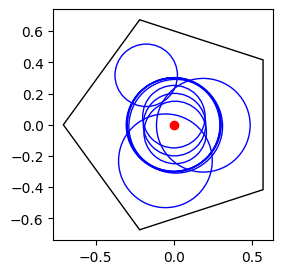

  0%|          | 1/10000 [00:01<3:56:34,  1.42s/it]

##########################


  0%|          | 38/10000 [01:00<4:23:33,  1.59s/it]


KeyboardInterrupt: 

In [10]:
################# INITIALIZING PARAMETERS ##############
BATCHES = 64
EPOCHS = 10000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(DEVICE)
RUNS = 4
PATIENCE = 50
CIRCUMRADIUS = 1/np.sqrt(2)

small_radius = torch.tensor(([0.3], [0.2], [0.3],[0.3], [0.2], [0.3],[0.3], [0.2], [0.3],[0.3], [0.2], [0.3]))                                                                      # Radius of the inner circle
num_circles = len(small_radius)                                                                                         # Number of circles
large_radius = CIRCUMRADIUS
no_of_peturbations = 5

################ CREATING DATASET ##################
eye = one_hot(np.arange(0, num_circles), num_circles)
Input = eye.repeat(BATCHES, 1, 1).to(DEVICE)



################## TRAINING LOOP ####################
max_density_runs = [0]*RUNS
run_reached = 0
for run in range(RUNS):
    run_reached += 1
    ############ DEFINE MODEL AND VARIABLES FOR THE RUN #################
    model = EncoderDecoder(num_circles, large_radius, small_radius, no_of_peturbations=no_of_peturbations).to(DEVICE)
    #model = torch.load('model_0.pth')
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.0005)  
    alpha = [2]*no_of_peturbations                                                                                  # Initial alpha
    beta = [8]*no_of_peturbations                                                                                   # Inital beta
    loss_list = []                                                                                                  # Loss list
    max_packing_density = 0                                                                                         # Maximum packing density till now
    curr_packing_density = 0                                                                                        # Current epoch packing density
    stagnation_counter = 0                                                                                          # Stagnation counter for scheduling beta distribution change

    ########### TRAINING MODEL #############
    for epoch in tqdm(range(EPOCHS)):

        epoch_loss = 0

        ########## MAXIMUM ALLOWED ALPHA AND MINIMUM ALLOWED BETA #############
        for i in range(len(beta)):
            if beta[i] < (2.0*((i+1)**(1/no_of_peturbations))):
                beta[i] = (2.0*((i+1)**(1/no_of_peturbations)))
        for i in range(len(alpha)):
            if alpha[i] > (16.0/((i+1)**(1/no_of_peturbations))):
                alpha[i] = 16.0

        for inputs in Input:
            optim.zero_grad()
            outputs = model(inputs, alpha, beta)
            curr_loss = loss(outputs, torch.cat([inputs.argmax(dim=1)]*no_of_peturbations, dim=0)) #inputs.argmax(dim=1))
            curr_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optim.step()
            epoch_loss += curr_loss.detach().cpu()
        
        ########## APPEND LOSS ##########
        loss_list.append(epoch_loss)

        ########### SAVE MAXIUMUM PACKING DENSITY YET MODEL ################## 
        centers = model.centers(eye)
        curr_packing_density = packing_density(centers,N,  small_radius, large_radius)
        if max_packing_density < curr_packing_density:
            max_packing_density =  curr_packing_density
            max_density_runs[run] = max_packing_density
            torch.save(model, f'model_{run}.pth')
    

        ########### CALCULATE STAGNATION FOR BETA DISTRIBUTION SCHEDULAR #############
        if (epoch > 0) and curr_packing_density < max_packing_density:
            stagnation_counter += 1
        else:
            stagnation_counter = 0
        
        ########## UPDATE BETA DISTRIBUTION #############
        if stagnation_counter >= PATIENCE:
            for i in range(len(beta)):
                alpha[i]+=0.28/(i+1)
                beta[i]-=0.6/(i+1)
                stagnation_counter = 0
        
        ########## PRINT PACKING ##############
        if epoch % 100 == 0:
            print(f"Epcoh {epoch}") 
            centers = model.centers(eye)
            print(f"Packing Density : {packing_density(centers, N, small_radius, large_radius)}")
            plot_circles(centers, large_radius, small_radius, N)
            print("##########################")

centres = model.centres(eye)
plot_circles(centres, large_radius, small_radius)

In [31]:
########### FINAL PLOTS AND PACKING DENSITY FOR BEST MODELS #################

for run in range(run_reached):
    print("##################################################################################")
    model = torch.load(f'model_{run}.pth')
    centres = model.centers(eye)
    print(f"Packing Density : {packing_density(centres, N, small_radius, large_radius, NumSamples=100000)}")
    plot_circles_final(centres, large_radius, small_radius, N, save=True)
    print("##################################################################################")

In [32]:
#################### MODEL WORKING VISUALIZATION PLOT #######################

from matplotlib.colors import ListedColormap, to_rgba_array

"""
IMPORTANT : CHANGE hex_colors to have as many colors as there are circles
"""
hex_colors = [
    '#dcdcdc', '#8b4513', '#708090', #'#808000', '#483d8b',
     '#3cb371', '#000080', '#9acd32', '#8b008b', '#48d1cc',
     '#ff4500', '#ffa500', '#ffff00', '#00ff00', '#8a2be2',
     '#00ff7f', '#00bfff', '#0000ff', '#ff00ff', '#1e90ff',
     '#db7093', '#f0e68c', '#ff1493', '#ffa07a', '#ee82ee',
     '#dff993', '#66e68c', '#edc033', '#afbf55', '#ad4512',
     '#b99b95', '#ababab', '#12a800', '#4a1150', '#ffddbb',
     '#b316ff', '#aff551', '#fd5522', '#a22f4d', '#afa552',
     '#ffffff', '#c256aa', '#cc4df5', '#ddd555', '#15a2d3',
]

hex_colors = hex_colors[:num_circles]
# Convert hex colors to RGBA format
rgba_colors = [to_rgba_array(color) for color in hex_colors]

# Create ListedColormap
custom_cmap = ListedColormap(rgba_colors, name='custom_cmap')

for run in range(run_reached):
    print("##################################################################################")
    model = torch.load(f'model_{run}.pth')
    print("VISUALIZATION OF THE PACKING") 
    centers = model.centers(eye)
    colors = custom_cmap
    print(colors)
    color_visualization_plot(centers, large_radius, small_radius,colors, N, save=False)
    model.regions(eye, alpha, beta, colors)
    print("##################################################################################")

In [ ]:
################################################################ END ######################################################################